<a href="https://colab.research.google.com/github/josebel78/03MIAR_Algoritmos-de-Optimizacion/blob/main/Algoritmos_Jose_Belenguer_AG3_reto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PhD-Paper-01-Const
## José Belenguer Ballester
### GitHub repository:
#### https://github.com/josebel78/PhD.git

## MODULE IMPORTS

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
from scipy import stats
import seaborn as sns
import time
import warnings

In [2]:
warnings.filterwarnings("ignore")

## DATA LOADING

In [3]:
def arrange_dependencies():

    # def arrange_dependencies()
        
    global dep_lists

    # A list of lists (dep_lists) is created from dep_dash to store the interdependencies:
        # In the simplest case, every item (list) will contain two elements: dep_job, prec_job
        # In more complex situations, every item (list) will contain multiple elements: dep_job, prec_job_1, prec_job_2...
    
    dep_lists = []
    
    for dep_job,prec_job in dep_dash.items():

        dep_job_in_dash = [dep_job in sublist for sublist in dep_lists]
        prec_job_in_dash = [prec_job in sublist for sublist in dep_lists]        

        if any(dep_job_in_dash) and any(prec_job_in_dash):
            prec_job_in_dash_idx = prec_job_in_dash.index(True)
            prec_job_in_dash_sublist = dep_lists.pop(prec_job_in_dash_idx)
            dep_job_in_dash_idx = dep_job_in_dash.index(True)
            dep_lists[dep_job_in_dash_idx].extend(prec_job_in_dash_sublist)
        elif any(dep_job_in_dash):
            dep_job_in_dash_idx = dep_job_in_dash.index(True)
            dep_lists[dep_job_in_dash_idx].append(prec_job)
        elif any(prec_job_in_dash):
            prec_job_in_dash_idx = prec_job_in_dash.index(True)
            dep_lists[prec_job_in_dash_idx].insert(0, dep_job)
        else:
            dep_lists.append([dep_job, prec_job])

    sublist_idx = 0
    # dependency_dict = {}

    while sublist_idx < len(dep_lists):
        dep_job = dep_lists[sublist_idx][0]
        prec_job = dep_lists[sublist_idx][-1]
        dep_job_in_dash = [dep_job in sublist for sublist in dep_lists[sublist_idx+1:]]
        prec_job_in_dash = [prec_job in sublist for sublist in dep_lists[sublist_idx+1:]]
        if any(dep_job_in_dash):
            dep_job_sublist = dep_lists.pop(sublist_idx)
            dep_job_in_dash_idx = dep_job_in_dash.index(True)
            dep_lists[dep_job_in_dash_idx].extend(dep_job_sublist[1:])
        elif any(prec_job_in_dash):
            prec_job_in_dash_idx = prec_job_in_dash.index(True)
            prec_job_in_dash_sublist = dep_lists.pop(prec_job_in_dash_idx)
            dep_lists[sublist_idx].extend(prec_job_in_dash_sublist[1:])
        else:
            sublist_idx += 1
    
    return None

In [4]:
def read_instance(file_name):
        
    global J, M, Rmax, dep_dash
    
    with open(file_name,"r") as file:
        data = file.readlines()
    
    # PROBLEM SPECIFICATIONS: Line #1: number of machines (M), and of jobs (J)
    specs = data[0].split()
    J = int(specs[0])
    M = int(specs[1])

    machine_names = data[1].split()[0::2]

    prec_lines = len(data) - (J+1)*2 - 2 # Number of lines for precedences in the instance file

    dep_dash = {}

    # PROCESSING TIMES: lines # 2 ... 2+J-1
    skiprows_times = 1
    skipfooter_times = prec_lines + (J + 3)
    processing_times_df = pd.read_csv(file_name,
                                      sep="\s+",
                                      header=None,
                                      names=machine_names,
                                      index_col=False,
                                      usecols=list(range(1,2*M,2)),
                                      dtype=np.int8,
                                      engine='python',
                                      skiprows=skiprows_times,
                                      skipfooter=skipfooter_times
                                     )

    # RESOURCES: lines # 2 + J ... 2 * (J + 1)
    skiprows_res = J + 2
    skipfooter_res = prec_lines + 2
    resources_df = pd.read_csv(file_name,
                               sep="\s+",
                               header=None,
                               names=machine_names,
                               index_col=False,
                               usecols=list(range(1,2*M,2)),
                               dtype=np.int8,
                               engine='python',
                               skiprows=skiprows_res,
                               skipfooter=skipfooter_res
                              )
    
    Rmax = int(data[(J+1)*2 + 1])
    
    # PRECEDENCES: lines # 2 + J ... 2 * (J + 1)
    if prec_lines > 1: # If 1 then 'Precedence' would be an empty field
        prec_array = np.full(shape=(J,), fill_value=None)
        for p in range(len(data)-prec_lines+1,len(data)):
            prec_line = data[p]
            prec_line = prec_line.split(':')
            prec_array[int(prec_line[0])] = int(prec_line[1])
            dep_dash.update({int(prec_line[0]) : int(prec_line[1])})
        arrange_dependencies()

    problem_df = pd.concat([processing_times_df, resources_df, pd.Series(prec_array)], axis=1, join='outer', copy=False)    
    
    # instance_name = instance.rstrip('.txt')
    # # print(f'\nInstance specifications: J = {J} jobs, M = {M} machines, prec = {prec_lines-1} precedence relationship(s), and Rmax = {Rmax} resources.')
    # print(f'\n\n# {instance_name}: J = {J} jobs, M = {M} machines, prec = {prec_lines-1} precedence relationship(s), and Rmax = {Rmax} resources.')

    return problem_df
    

## DATA STRUCTURING

In [5]:
class Job:
    def __init__(self, index, p_times, res, prec):
        self.index = int(index) # Index (name) of the job as an int
        self.p_times = p_times # Processing times on each machine as a NumPy array of float
        self.res = res # Job resources on each machine as a NumPy array of float
        self.prec = prec # Previous job (with a precedence relation) as an int
        self.cost = np.empty(shape=(M,), dtype=np.int8) # Job cost on each machine derived from the assignment rule as a NumPy array
        # self.cost = int(0) # Job's assigned cost


In [6]:
class Machine:
    def __init__(self, index):
        self.index = int(index) # Index (name) of the machine as an int
        self.job_seq = np.empty(shape=(0)) #, dtype=np.int8) # Job sequence on the machine as a NumPy array
        self.job_times = np.empty(shape=(0), dtype=np.int8) # Job processing time on the machine as a NumPy array
        self.s_times = np.empty(shape=(0), dtype=np.int8) # Job processing time on the machine as a NumPy array
        self.e_times = np.empty(shape=(0), dtype=np.int8) # Job processing time on the machine as a NumPy array
        self.t_spans = {}
        self.job_res = np.empty(shape=(0), dtype=np.int8) # Job resources on the machine at every instant as a NumPy array
        self.C = int(0) # Machine makespan as an int
        
    def reset(self):
        self.job_seq = np.empty(shape=(0)) #, dtype=np.int8) # Job sequence on the machine as a NumPy array
        self.job_times = np.empty(shape=(0), dtype=np.int8) # Job processing time on the machine as a NumPy array
        self.s_times = np.empty(shape=(0), dtype=np.int8) # Job processing time on the machine as a NumPy array
        self.e_times = np.empty(shape=(0), dtype=np.int8) # Job processing time on the machine as a NumPy array
        self.t_spans.clear()
        self.job_res = np.empty(shape=(0), dtype=np.int8) # Job resources on the machine as a NumPy array
        self.C = int(0) # Machine makespan as an int
        
    def program_job(self, job, pos=-1):
        # Every parameter's length will be:
            # s_times, e_times, job_times, job_seq: J
            # job_res: C-1
        if pos == -1:
            job_s_time = int(0) if (self.job_seq.size == 0) else int(self.C)
            job_e_time = job_s_time + job.p_times[self.index]
            self.s_times = np.append(self.s_times, job_s_time)
            self.e_times = np.append(self.e_times, job_e_time)
            self.job_times = np.append(self.job_times, job.p_times[self.index])
            self.job_res = np.append(self.job_res, job.res[self.index]*np.ones(shape=(job.p_times[self.index],)))
            self.job_seq = np.append(self.job_seq, job)
        else:
            job_s_time = int(0) if (self.job_seq.size == 0) else int(self.s_times[pos])
            job_e_time = job_s_time + job.p_times[self.index]
            self.s_times = np.concatenate((self.s_times[:pos], 
                                           np.array([job_s_time]), 
                                           self.s_times[pos:] + job.p_times[self.index]))
            self.e_times = np.concatenate((self.e_times[:pos], 
                                           np.array([job_e_time]), 
                                           self.e_times[pos:] + job.p_times[self.index]))
            self.job_times = np.concatenate((self.job_times[:pos], 
                                             np.array([job.p_times[self.index]]), 
                                             self.job_times[pos:]))
            self.job_res = np.concatenate((self.job_res[:job_s_time], 
                                             job.res[self.index]*np.ones(shape=(job.p_times[self.index],)), 
                                             self.job_res[job_s_time:]))
            self.job_seq = np.concatenate((self.job_seq[:pos], 
                                           np.array([job]), 
                                           self.job_seq[pos:]))
        self.t_spans.clear()
        for j in range(len(self.job_seq)):
            self.t_spans.update({self.job_seq[j].index: (self.s_times[j], self.e_times[j])})
        self.C = self.e_times[-1] # Machine makespan as an int
        

In [7]:
def create_jobs(problem_df):
    
    # def create_jobs(problem_df):
        # It creates the problem's job list.
        # It returns a list of objects of the job class which are constructed by reading the corresponding information from the problem_df
    
    job_list = []

    for j in range(J):
        p_times = np.array(list(problem_df.iloc[j,:M]))
        res = np.array(list(problem_df.iloc[j,M:2*M]))
        prec = int(problem_df.iloc[j,2*M]) if isinstance(problem_df.iloc[j,2*M], int) else problem_df.iloc[j,2*M] # Precedent job nº; otherwise, None
        job = Job(j, p_times, res, prec)
        job_list.append(job)

    return job_list
    

In [8]:
def create_machines(num_machines):
    
    # def create_machines(num_machines):
        # It creates the problem's machine list.
        # It returns a list of objects of the mach class which are constructed by reading the corresponding information from the problem_df   
    
    machine_list = [Machine(m) for m in range(num_machines)]

    return machine_list
        

## DATA VISUALISATION

In [9]:
def display_solution(solution):
    
    # Display of a solution
    
    for machine in solution:
        print(f'\nMachine M{machine.index}:')
        print(f'Job sequence: \t\t {[job.index for job in machine.job_seq]}')
        print(f'Start times: \t\t {machine.s_times}')
        print(f'Processing times: \t {machine.job_times}')
        print(f'End times: \t\t {machine.e_times}')
        print(f'Resources: \t\t {machine.job_res}')
        print(f'Makespan: \t\t C = {machine.C}')

    C_max = max([machine.C for machine in solution])
    print(f'\nThe maximum makespan is C_max: {C_max}')
    
    return None

## SOLUTION FEASIBILITY

In [10]:
def assess_feasibility(solution, job_dash):
        
    # def assess_feasibility(solution, job_dash):
        # Assesses whether a solution to the problem is feasible or unfeasible. Along with this condition, the function returns:
            # If feasible, sol_cost = sol_Cmax.
            # If unfeasible, sol_cost = sol_Cmax + (e_time_prec - s_time_dep) + abs(np.sum(acc_res - Rmax_res)).

    ############################ DEPENDENCIES ############################

    sol_Cmax = max([machine.C for machine in solution])
    res_matrix = np.zeros(shape=(M,sol_Cmax))
    sol_cost = sol_Cmax

    prec_ok = True
        
    # search of dependencies based on dep_dash
        # For the dependent job:
            # We find the machine where it was scheduled, and the time when it starts.
        # For the precedent job:
            # We find the machine where it was scheduled, and the time when it ends.
        # We check whether the dependent job starts no sooner than the precedent job has finished.
        # If that is not the case, we label the solution as unfeasible and calculate a penalty cost.

    for dep_job_idx, prec_job_idx in dep_dash.items():
        
        # Dependent job information
        dep_machine_idx = job_dash.get(dep_job_idx)
        dep_machine = solution[dep_machine_idx]
        s_time_dep = dep_machine.t_spans.get(dep_job_idx)[0]
        
        # Precedent job information
        prec_machine_idx = job_dash.get(prec_job_idx)
        prec_machine = solution[prec_machine_idx]
        e_time_prec = prec_machine.t_spans.get(prec_job_idx)[1]
        
        if s_time_dep < e_time_prec:
            prec_ok = False
            sol_cost += (e_time_prec - s_time_dep)
            break

    ############################ RESOURCES ############################
    
    # Resource requirements are analysed:
        # Cumulative use of resources in all machines at every instant of time is calculated.
        # The res_ok condition is set to False as soon as Rmax is exceeded.
        
    for machine in solution:
        res_matrix[machine.index, :machine.C] = np.transpose(machine.job_res)    
    
    acc_res = np.sum(res_matrix, axis=0)
    Rmax_res = Rmax*np.ones_like(acc_res)
    res_ok = True if np.all(acc_res <= Rmax) else False
    sol_cost += 0 if res_ok else abs(np.sum(acc_res - Rmax_res))
    
    return int(sol_cost), prec_ok, res_ok


# CONSTRUCTIVE PHASE

In [11]:
def construct_rcl(pre_sol, job_list, rule, alpha):

    # def construct_rcl(pre_sol, job_dict, rule, alpha):
        # It constructs a restricted candidate list (RCL).
        # Pending jobs are sorted on every machine according to their cost value.
    
    rcl_dict = {}
    _ = [rcl_dict.update({m: []}) for m in range(M)]
    
    c_list = []

    # Assign jobs to machines where the cost is minimum.
        # To solve situations in which the cost is minimum on more than one machine, we always use random.choice.
        # This solution randomises the deterministic behaviour of np.argmin which alwais assigned the job to the first machine in case of a tie.

    for job in job_list:
        job_cost_min = min(job.cost)
        job_cost_min_idx = [m for m in range(M) if job.cost[m]==job_cost_min] # Works for more than one job with equal costs
        m = random.choice(job_cost_min_idx)
        rcl_dict[m].append(job)
        c_list.append(job.cost[m])

    cost_min = min(c_list)
    cost_max = max(c_list)
    
    match rule:
    
        case 'SPT' | 'LRR' | 'DJP' | 'LRR-SPT-IDM' | 'LRR-LPT-IDM':
            for m in range(M):
                rcl_dict[m].sort(key=lambda x: x.cost[m], reverse=False)

            range_start = cost_min
            range_end = cost_min + alpha * (cost_max- cost_min)
    
            # Pending jobs outside the limits of the RCL are removed.
        
            for m, job_list in rcl_dict.items():
                L = len(job_list)-1
                for j in range(L, -1, -1):
                    if job_list[j].cost[m] > range_end:
                        job_list.pop()
                    else:
                        break
                rcl_dict.update({m : job_list})

        case 'LPT' | 'MRR' | 'IJP' | 'IDM' | 'MRR-SPT-IDM' | 'MRR-LPT-IDM':
            for m in range(M):
                rcl_dict[m].sort(key=lambda x: x.cost[m], reverse=True)

            range_start = cost_max
            range_end = cost_max - alpha * (cost_max - cost_min)
    
            # Pending jobs outside the limits of the RCL are removed.
        
            for m, job_list in rcl_dict.items():
                L = len(job_list)-1
                for j in range(L, -1, -1):
                    if job_list[j].cost[m] < range_end:
                        job_list.pop()
                    else:
                        break
                rcl_dict.update({m : job_list})

    return rcl_dict


In [12]:
def select_candidate(rcl_dict):
    
    candidate_machine_index = None
    candidate_job_index = None
    
    candidate_machine_list = [machine_index for machine_index in rcl_dict.keys() if len(rcl_dict[machine_index]) > 0]
    candidate_machine_index = random.choice(candidate_machine_list)
    candidate_job_index = random.choice(rcl_dict[candidate_machine_index]).index

    return candidate_machine_index, candidate_job_index


In [13]:
def construct_initial_solution(job_list, rule, alpha):

    # Creation of a dictionary with items defined by:
        # keys: indices of the machines
        # values: list of jobs sorted by the SPT rule (processing times in non-decreasing order on each machine)    
    
    job_dict = {}
    job_dash = {}

    if rule in ['SPT', 'LPT', 'LRR', 'MRR', 'DJP', 'IJP', 'IDM']:
        rule_class = 'simple'
    elif rule in ['LRR-SPT-IDM', 'LRR-LPT-IDM', 'MRR-SPT-IDM', 'MRR-LPT-IDM']:
        rule_class = 'composite'    

    match rule_class:

        case 'simple':

        ############################ SIMPLE ASSIGNMENT RULES ############################
    
            match rule:
    
            # The lists generated by the following rules will NOT be reversed: 'SPT', 'LRR', 'DJP'.
            # The lists generated by the following rules will be reversed: 'LPT', 'MRR', 'IJP', 'IDM'.
            
                case 'SPT' | 'LPT':
                    # Job's costs are its processing times on every machine
                    for job in job_list:
                        for m in range(M):                    
                            job.cost[m] = job.p_times[m]
            
                case 'LRR' | 'MRR':
                    # Job's costs are its resource consumption on every machine
                    for job in job_list:
                        for m in range(M):                    
                            job.cost[m] = job.res[m]
                
                case 'DJP' | 'IJP' | 'IDM':
                    # Job's costs depend on its position in the dependency lists and on the assignment rule
                    reversed_dep_lists = copy.deepcopy(dep_lists)
                    flattened_dep_lists = []
                    for dep_sublist in reversed_dep_lists:
                        dep_sublist.reverse()
                        flattened_dep_lists.extend(dep_sublist)

                    max_cost = 0
                    for job in job_list:
                        # Default (DJP): dependent job's costs are its position in the dependency (sub)list; independent job's costs are zero
                        if job.index in flattened_dep_lists:
                            for dep_sublist in reversed_dep_lists:
                                if job.index in dep_sublist:
                                    dep_job_pos = dep_sublist.index(job.index)
                                    job.cost = dep_job_pos * np.ones(shape=(M,))
                                    if dep_job_pos > max_cost:
                                        max_cost = dep_job_pos
                                    break
                        else:
                            job.cost = np.zeros(shape=(M,))
                    
                    if  rule == 'IJP':
                        # IJP: dependent job's costs are zero; independent job's costs are one
                        for job in job_list:
                            job.cost = np.zeros(shape=(M,)) if job.cost[0] > 0 else np.ones(shape=(M,))

                    elif rule == 'IDM':
                        # IDM: dependent job's costs are its position in the dependency (sub)list; independent job's costs are (max_cost + 1)
                        for job in job_list:
                            if job.cost[0] == 0:
                                job.cost = (max_cost + 1) * np.ones(shape=(M,))

        case 'composite':

        ############################ COMPOSITE ASSIGNMENT RULES ############################
    
            p_time_avg = 0
            res_avg = 0
            prec_avg = 0
                
            # Job's costs depend on its position in the dependency lists and on the assignment rule
            reversed_dep_lists = copy.deepcopy(dep_lists)
            flattened_dep_lists = []
            for dep_sublist in reversed_dep_lists:
                dep_sublist.reverse()
                flattened_dep_lists.extend(dep_sublist)

            max_cost = 0
            for job in job_list:
                # Default (DJP): dependent job's costs are its position in the dependency (sub)list; independent job's costs are zero
                if job.index in flattened_dep_lists:
                    for dep_sublist in reversed_dep_lists:
                        if job.index in dep_sublist:
                            dep_job_pos = dep_sublist.index(job.index)
                            job.cost = dep_job_pos * np.ones(shape=(M,))
                            if dep_job_pos > max_cost:
                                max_cost = dep_job_pos
                            break
                else:
                    job.cost = np.zeros(shape=(M,))
                    
            # IDM: dependent job's costs are its position in the dependency (sub)list; independent job's costs are (max_cost + 1)
            for job in job_list:
                if job.cost[0] == 0:
                    job.cost = (max_cost + 1) * np.ones(shape=(M,))
                p_time_avg += np.sum(job.p_times)
                res_avg += np.sum(job.res)
                prec_avg += np.sum(job.cost)

            p_time_avg = p_time_avg / (J*M)
            res_avg = res_avg / (J*M)
            prec_avg = prec_avg / (J*M)

            # p_time_avg += p_time_avg / (J*M)
            # res_avg += res_avg / (J*M)
            # prec_avg += prec_avg / (J*M)

            # print(f'\np_time_avg: {p_time_avg}')
            # print(f'\nres_avg: {res_avg}')
            # print(f'\nprec_avg: {prec_avg}')
            
            # res_factor = 1
            # time_factor = 1
            # prec_factor = 1

            # res_factor = p_time_avg // res_avg
            # time_factor = 1.0
            # prec_factor = p_time_avg // prec_avg

            # print(f'\nres_factor: {res_factor}')
            # print(f'\ntime_factor: {time_factor}')
            # print(f'\nprec_factor: {prec_factor}')
            # print(f'\nprec_factor: {prec_factor*J}')
                
            match rule:
    
            # The lists generated by the following rules will NOT be reversed: 'LRR-SPT-IDM', 'LRR-LPT-IDM'.
            # The lists generated by the following rules will be reversed: 'MRR-SPT-IDM', 'MRR-LPT-IDM'.
            
                case 'LRR-SPT-IDM':
                    # a=0
                    # b=0
                    # c=0
                    for j in range(J):
                        for m in range(M):
                            # job_list[j].cost[m] += (res_factor * job_list[j].res[m]) + (time_factor * job_list[j].p_times[m]) - (prec_factor * job_list[j].cost[m])
                            job_list[j].cost[m] = (job_list[j].res[m] / res_avg) + (job_list[j].p_times[m] / p_time_avg) - (job_list[j].cost[m] / prec_avg)
                            # job_list[j].cost[m] += math.floor((job_list[j].res[m] - res_avg) + (job_list[j].p_times[m] - p_time_avg) - (job_list[j].cost[m] - prec_avg))
                            # a = job_list[j].res[m] - res_avg
                            # b = job_list[j].p_times[m] - p_time_avg
                            # c = job_list[j].cost[m] - prec_avg
                            # print(f'a, b, c: {a, b, c}')
            
                case 'LRR-LPT-IDM':
                    for j in range(J):
                        for m in range(M):
                            # job_list[j].cost[m] += (res_factor * job_list[j].res[m]) - (time_factor * job_list[j].p_times[m]) - (prec_factor * job_list[j].cost[m])
                            job_list[j].cost[m] = (job_list[j].res[m] / res_avg) - (job_list[j].p_times[m] / p_time_avg) - (job_list[j].cost[m] / prec_avg)
                            # job_list[j].cost[m] += math.floor((job_list[j].res[m] - res_avg) - (job_list[j].p_times[m] - p_time_avg) - (job_list[j].cost[m] - prec_avg))
                    # a = (res_factor * job_list[j].res[m])
                    # b = (time_factor * job_list[j].p_times[m])
                    # c = (prec_factor * job_list[j].cost[m])
                    # print(f'a, b, c: {a, b, c}')
                
                case 'MRR-SPT-IDM':
                    for j in range(J):
                        for m in range(M):
                            # job_list[j].cost[m] += (res_factor * job_list[j].res[m]) - (time_factor * job_list[j].p_times[m]) + (prec_factor * job_list[j].cost[m])
                            job_list[j].cost[m] = (job_list[j].res[m] / res_avg) - (job_list[j].p_times[m] / p_time_avg) + (job_list[j].cost[m] / prec_avg)
                            # job_list[j].cost[m] += math.floor((job_list[j].res[m] - res_avg) - (job_list[j].p_times[m] - p_time_avg) + (job_list[j].cost[m] - prec_avg))
                    # a = (res_factor * job_list[j].res[m])
                    # b = (time_factor * job_list[j].p_times[m])
                    # c = (prec_factor * job_list[j].cost[m])
                    # print(f'a, b, c: {a, b, c}')
            
                case 'MRR-LPT-IDM':
                    for j in range(J):
                        for m in range(M):
                            # job_list[j].cost[m] += (res_factor * job_list[j].res[m]) + (time_factor * job_list[j].p_times[m]) + (prec_factor * job_list[j].cost[m])
                            job_list[j].cost[m] = (job_list[j].res[m] / res_avg) + (job_list[j].p_times[m] / p_time_avg) + (job_list[j].cost[m] / prec_avg)
                            # job_list[j].cost[m] += math.floor((job_list[j].res[m] - res_avg) + (job_list[j].p_times[m] - p_time_avg) + (job_list[j].cost[m] - prec_avg))
                    # a = (res_factor * job_list[j].res[m])
                    # b = (time_factor * job_list[j].p_times[m])
                    # c = (prec_factor * job_list[j].cost[m])
                    # print(f'a, b, c: {a, b, c}')

    # There are two options to create the initial job_dict:
    #     To transfer the complete job_list, and then to assign each job to one machine in the construct_rcl function.
    #     To transfer each job to the machine in which its cost is the minimum. This option avoids executing the for loop every time the construct_rcl function is called.
    
    _ = [job_dict.update({m: copy.deepcopy(job_list)}) for m in range(M)]
    pending_job_list = copy.deepcopy(job_list)
    
    pending_jobs = J
    
    machine_env = create_machines(M)
    _ = [machine.reset() for machine in machine_env]    
    
    while pending_jobs > 0:
        
        rcl_dict = construct_rcl(machine_env, pending_job_list, rule, alpha)
        candidate_machine_index, candidate_job_index = select_candidate(rcl_dict)
        
        # Assign the SPT job to the corresponding machine and remove it from the rest
        
        job_pos = [job.index for job in pending_job_list].index(candidate_job_index) #[0][0]
        candidate_job = pending_job_list.pop(job_pos)
        machine_env[candidate_machine_index].program_job(candidate_job)
        job_dash.update({candidate_job_index : candidate_machine_index})
        
        pending_jobs -= 1
        
    initial_Cmax, initial_prec_ok, initial_res_ok  = assess_feasibility(machine_env, job_dash)
    # initial_feasibility = initial_prec_ok and initial_res_ok
    initial_dict = {initial_Cmax : machine_env}

    return initial_dict, machine_env, initial_Cmax, initial_prec_ok, initial_res_ok, job_dash
    

## SOLUTION REPAIRING

In [14]:
def internal_swap(unsorted_sol, m_index, dep_job_index, prec_job_index, job_dash_u):
    
    # This function is called only when a dependent job is processed before its precedent job 
    sorted_sol = copy.deepcopy(unsorted_sol)
    sorted_sol[m_index].reset()

    job_dash_s = job_dash_u.copy()
    
    unsorted_job_list = [job for job in unsorted_sol[m_index].job_seq]
    unsorted_job_list_indices = [job.index for job in unsorted_job_list]

    dep_job_pos = unsorted_job_list_indices.index(dep_job_index)
    prec_job_pos = unsorted_job_list_indices.index(prec_job_index)

    # Firstly, jobs before the dependent one are re-programmed as they were
    for pos, idx in enumerate(unsorted_job_list_indices):
        
        if idx == dep_job_index:
            p = prec_job_pos
        elif idx == prec_job_index:
            p = dep_job_pos
        else:
            p = pos
        
        j = unsorted_job_list[p]
            
        sorted_sol[m_index].program_job(j)
        job_dash_s.update({j : m_index})
    
    return sorted_sol, job_dash_s
    

In [15]:
def repair(unfeasible_dict, repaired_prec_ok, repaired_res_ok, job_dash_u, repair_time_limit):

    # def repair(unfeasible_dict, repaired_prec_ok, repaired_res_ok, job_dash_u, repair_time_limit):
        # job_dash_u: job dash of the unfeasible solution to be repaired
        
    # To repair an unfeasible solution:
        # Soluctions with precedence relationships are sought
        # Starting times times of those jobs are compared against the finishing times of the precedent jobs 
    
    repair_iter = 0
    repair_time = 0
    repair_prep_start_time = time.monotonic()
    
    job_dash_i = job_dash_u.copy() # intermediate
    job_dash_r = job_dash_u.copy() # repaired
    time_span_dict_m = {}
    dependency_dict = {}
    dependency_list = []
    repaired_dict = {}
    
    best_u_Cmax = min(unfeasible_dict.keys())
    unfeasible_sol = unfeasible_dict.get(best_u_Cmax)
    repaired_sol = copy.deepcopy(unfeasible_sol)

    sol_Cmax = best_u_Cmax
    res_matrix = np.zeros(shape=(M,sol_Cmax))

    # Precedence relationships are stored in a dictionary (dependency_dict) with the following info:
        # key: a tuple comprising the dependent job's machine index and job index
        # value: a tuple comprising a boolean stating whether both jobs are in the same machine, and the precedent job's index
    # Parallelly, jobs' start and end times are stored as tuples in another dictionary (time_span_dict_m)
    # Finally, the resources required by every job at every instant of time are stored in a matrix (res_matrix)
    
    for machine in unfeasible_sol:
        res_matrix[machine.index, :machine.C] = np.transpose(machine.job_res)
        
    for dep_job_idx, prec_job_idx in dep_dash.items():
        
        dep_machine_idx = job_dash_u.get(dep_job_idx)
        prec_machine_idx = job_dash_u.get(prec_job_idx)
        dependency_dict[(dep_machine_idx,dep_job_idx)] = (prec_machine_idx,prec_job_idx)        

    reversed_dependency_list = copy.deepcopy(dep_lists)
    _ = [item.reverse() for item in reversed_dependency_list]        
    
    # Precedence relationships are revised:
        # If both jobs are in the same machine, and the dependent job is processed before the precedent job, they are immediately swapped
        # In other cases, the precedence relationships will be fixed afterwards, whenever necessary

    # The following processing would not be necessary if only simple precedence relationships existed. 
    # However, it becomes necessary when complex precedence relationships may arise.

    dep_job_info_list = list(dependency_dict.keys()) # list of tuples (dep_machine_idx,dep_job_idx)

    idle_job = Job(index=int(J), p_times=np.ones(shape=(M,), dtype=np.int8), res=np.zeros(shape=(M,), dtype=np.int8), prec=None)
    
    repair_prep_end_time = time.monotonic()
    repair_prep_time = (repair_prep_end_time - repair_prep_start_time)
    repair_time += repair_prep_time
    
    repaired_sol_feasibility = repaired_prec_ok and repaired_res_ok
    
    while (repair_time < repair_time_limit) and (not repaired_sol_feasibility):

        repair_iter += 1
        
        if not repaired_prec_ok:

            ############################ PRECEDENCE RELATIONSHIPS ############################

            repair_prec_start_time = time.monotonic()
            
            for dep_seq in reversed_dependency_list:

                for i in dep_seq[1:]:

                    pos_list = [True if i == dep_job_tuple[1] else False for dep_job_tuple in dep_job_info_list]
                    pos = pos_list.index(True)

                    dep_job_info = dep_job_info_list[pos] # dep_job_info = (dep_machine_idx,dep_job_idx)
                    prec_job_info = dependency_dict.get(dep_job_info) # prec_job_info = (prec_machine_idx,prec_job_idx)
                    
                    dep_machine = repaired_sol[dep_job_info[0]]
                    prec_machine = repaired_sol[prec_job_info[0]]
                    
                    s_time_dep = dep_machine.t_spans.get(dep_job_info[1])[0]
                    e_time_dep = dep_machine.t_spans.get(dep_job_info[1])[1]
                    s_time_prec = prec_machine.t_spans.get(prec_job_info[1])[0]
                    e_time_prec = prec_machine.t_spans.get(prec_job_info[1])[1]
                    
                    if s_time_dep < e_time_prec:

                        if dep_machine == prec_machine:
                            repaired_sol, job_dash_i = internal_swap(repaired_sol, dep_job_info[0], dep_job_info[1], prec_job_info[1], job_dash_i)
                        else:
                            job_indices = [j.index for j in dep_machine.job_seq]
                            pos_dep_job = job_indices.index(dep_job_info[1])
                            for d in range(e_time_prec-s_time_dep):
                                dep_machine.program_job(idle_job, int(pos_dep_job)) # dep_machine = repaired_sol[dep_job_info[0]]

                        # Update the resource matrix, and time spans in the corresponding dictionary:
                        sol_Cmax = max([machine.C for machine in repaired_sol])
                        res_matrix = np.zeros(shape=(M,sol_Cmax))

                        for machine in repaired_sol:
                            res_matrix[machine.index, :machine.C] = np.transpose(machine.job_res)

                repair_Cmax, repaired_prec_ok, repaired_res_ok = assess_feasibility(repaired_sol, job_dash_i)

                if repaired_prec_ok:
                    break
            
            repair_prec_end_time = time.monotonic()
            repair_prec_time = (repair_prec_end_time - repair_prec_start_time)
            repair_time += repair_prec_time
            
        elif not repaired_res_ok:

            ####################################################### RESOURCES #######################################################

            # Resources exceeded: This happens when a new job starts
            
            repair_res_start_time = time.monotonic()

            acc_res = np.sum(res_matrix, axis=0)
            repaired_res_ok = True if np.all(acc_res <= Rmax) else False

            p_x_res = np.where(acc_res > Rmax)[0][0] # Index where maximum resources are first exceeded. It will always be ind_x_res <= Cmax.

            candidate_machine_idx = [machine.index for machine in repaired_sol if (p_x_res in machine.s_times)]
            candidate_machine_C = [machine.C if (machine.index in candidate_machine_idx) else np.inf for machine in repaired_sol]
            candidate_machine_C_idxd = list(enumerate(candidate_machine_C))
            sorted_candidate_machine_C_idxd = sorted(candidate_machine_C_idxd, key=lambda x: x[1])

            m_idx = 0

            while (acc_res[p_x_res] > Rmax) and (sorted_candidate_machine_C_idxd[m_idx][1] < np.inf):
                idle_m_index = sorted_candidate_machine_C_idxd[m_idx][0]
                idle_j_pos = np.where(repaired_sol[idle_m_index].s_times == p_x_res)[0][0]
            
                repaired_sol[idle_m_index].program_job(idle_job, int(idle_j_pos))
                sol_Cmax = max([machine.C for machine in repaired_sol])
                
                res_matrix = np.zeros(shape=(M,sol_Cmax))
            
                for machine in repaired_sol:
    
                    res_matrix[machine.index, :machine.C] = np.transpose(machine.job_res)               
                
                acc_res = np.sum(res_matrix, axis=0)
            
                m_idx += 1
            
            repair_Cmax, repaired_prec_ok, repaired_res_ok = assess_feasibility(repaired_sol, job_dash_i)
        
            repair_res_end_time = time.monotonic()
            repair_res_time = (repair_res_end_time - repair_res_start_time)
            repair_time += repair_res_time

        repaired_sol_feasibility = repaired_prec_ok and repaired_res_ok
    
    repaired_dict.update({sol_Cmax : repaired_sol})
    job_dash_r.update(job_dash_i)

    return repaired_dict, repair_Cmax, repaired_prec_ok, repaired_res_ok, job_dash_r
    

In [16]:
def generate_solution(solution):
    
    # Generate a solution

    solution_dict = {}
    len_job_seq = []
    
    for machine in solution:
        job_list = [job.index for job in machine.job_seq]
        start_times = machine.s_times
        job_tuples = [(start_times[i], job_list[i]) for i in range(len(job_list)) if job_list[i] != J]
        solution_dict.update({machine.index: job_tuples})
        len_job_seq.append(len(job_tuples))
        
    
    for k,v in solution_dict.items():
        append_v = np.nan*np.ones(max(len_job_seq) - len(v))
        new_v = v + append_v.tolist()
        solution_dict.update({k:new_v})
        
    solution_df = pd.DataFrame.from_dict(solution_dict, orient='columns')
    
    return solution_df

# GRAPHICAL AND TEXTUAL OUTPUT

In [17]:
def output_solution(summary_df, alpha_values, makespan_columns, rpd_makespan_columns, g_rule, output_path):

    columns = ['Feasibility', 'Alpha', 'RPD Cmax']

    summary_rpd_df = pd.DataFrame()
    for c in range(4, summary_df.shape[1], 4):
        column_idx_ls = [3] + [c] + [c+3]
        summary_rpd_aux_df = pd.DataFrame(data=summary_df.iloc[:,column_idx_ls])
        summary_rpd_aux_df.columns = columns
        summary_rpd_df = pd.concat([summary_rpd_df, summary_rpd_aux_df], axis=0, ignore_index=True)
    
    hue_order=[False, True]
    palette = {False: 'red', True: 'green'}
    print('\n\n')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 5)) #, sharex=True)

    fig_name = 'RPD_' + g_rule + '_Repair'
    fig.suptitle(fig_name.replace("_", " "))
    x_values = summary_rpd_df['Alpha'].unique()
    x_labels = [round(x_value, 4) for x_value in x_values]
    
    ax1 = sns.boxplot(data=summary_rpd_df, x='Alpha', y='RPD Cmax', hue="Feasibility", 
                      hue_order=hue_order,
                      palette=palette,
                      fill=False, gap=.1, 
                      ax=ax1,
                      showfliers=False)

    ax1.set_xlabel('')
    ax1.set_xticklabels(x_labels)
    ax1.set_ylabel('RPD Cmax')

    ax1.legend(
        title='Solution feasibility', loc='lower center', bbox_to_anchor=(0.5, -0.5),
        ncol=2, fontsize='small'
    )    
    
    ax2 = sns.boxplot(data=summary_rpd_df[summary_rpd_df["Feasibility"]==True], x='Alpha', y='RPD Cmax',
                      color='green',
                      fill=False, gap=.1, 
                      ax=ax2,
                      showfliers=False)

    # Set y-limits with padding
    # y_min, y_max = 0, 1
    # padding = 0.05 * (y_max - y_min)  # 5% padding above and below
    # ax2.set_ylim([y_min - padding, y_max + padding])

    ax2.set_xlabel('alpha')
    ax2.set_xticklabels(x_labels)
    ax2.set_ylabel('RPD Cmax')
    
    sns.despine()
    plt.tight_layout()
    output_fig_path = output_path / (fig_name + '.png')
    plt.savefig(output_fig_path)
    plt.show()

    ############################ LATEX CODE ############################

    # summary_rpd_df = pd.DataFrame()
    columns_to_latex = ['Size'] + makespan_columns + rpd_makespan_columns
    summary_rpd_df = summary_df[summary_df['Feasibility']==True]
    summary_rpd_df = summary_rpd_df.loc[:, columns_to_latex]

    # cmax_columns_to_latex = ['Size'] + makespan_columns
    # summary_cmax_df = summary_df[summary_df['Feasibility']==True]
    # summary_cmax_df = summary_cmax_df.loc[:, cmax_columns_to_latex]

    # rpd_columns_to_latex = ['Size'] + rpd_makespan_columns
    # summary_rpd_df = summary_df[summary_df['Feasibility']==True]
    # summary_rpd_df = summary_rpd_df.loc[:, rpd_columns_to_latex]
    
    job_ls = []
    machine_ls = []
    for size in summary_rpd_df['Size']:
        size_elements = size.split('x')
        job_ls.append(size_elements[0]) 
        machine_ls.append(size_elements[1])

    # summary_cmax_df.drop(columns=['Size'], inplace=True)
    # summary_cmax_df.insert(loc=0, column='n', value=job_ls)
    # summary_cmax_df.insert(loc=0, column='m', value=machine_ls)

    summary_rpd_df.drop(columns=['Size'], inplace=True)
    summary_rpd_df.insert(loc=0, column='n', value=job_ls)
    summary_rpd_df.insert(loc=0, column='m', value=machine_ls)

    cmax_tuples = []
    rpd_tuples = []
    for alpha in alpha_values:
        cmax_tuples.append(('Cmax', '$\\alpha='+str(alpha)+'$'))
        rpd_tuples.append(('RPD Cmax', '$\\alpha='+str(alpha)+'$'))
    # tuples_to_latex = [('Size', '')] + makespan_tuples + rpd_makespan_tuples
    tuples_to_latex = [('n', ''), ('m', '')] + cmax_tuples + rpd_tuples
    # print(tuples_to_latex)
    # cmax_tuples_to_latex = [('n', ''), ('m', '')] + cmax_tuples
    # rpd_tuples_to_latex = [('n', ''), ('m', '')] + rpd_tuples

    summary_rpd_df.columns = pd.MultiIndex.from_tuples(tuples_to_latex)
    # summary_cmax_df.columns = pd.MultiIndex.from_tuples(cmax_tuples_to_latex)
    # summary_rpd_df.columns = pd.MultiIndex.from_tuples(rpd_tuples_to_latex)
    print('\n\n' + str(' RPD Makespan Summary ').center(124, '#')) # 160
    summary_latex_code = summary_rpd_df.to_latex(na_rep='\\phantom{0}', 
                                                 float_format="%.2f", column_format='r'*summary_rpd_df.shape[1], 
                                                 decimal='.', 
                                                 multicolumn=True, 
                                                 multicolumn_format='c', 
                                                 multirow=False, 
                                                 index=False)
    summary_latex_code = (
        "\n" + r"\begin{table}[!ht]"
        + "\n" + r"\centering" 
        + "\n" + r"\caption{" + g_rule + ' with repair procedure'"}"
        + "\n" + r"\label{tab:const_" + g_rule + '_repair'"}"
        + "\n" + r"\begin{adjustbox}{max width=\textwidth}" 
        + "\n" + summary_latex_code
        + "\end{adjustbox}" 
        + "\n" + r"\end{table}"
    )
    print(summary_latex_code)
    # cmax_latex_code = summary_cmax_df.to_latex(na_rep='\\phantom{0}', 
    #                                            float_format="%.2f", 
    #                                            column_format='r'*summary_rpd_df.shape[1], 
    #                                            decimal='.', 
    #                                            multicolumn=True, 
    #                                            multicolumn_format='c', 
    #                                            multirow=False, 
    #                                            index=False)
    # cmax_latex_code = r"\setlength{\tabcolsep}{2pt}" + "\n" + cmax_latex_code
    # print(cmax_latex_code)
    # rpd_latex_code = summary_rpd_df.to_latex(na_rep='\\phantom{0}', 
    #                                          float_format="%.2f", 
    #                                          column_format='r'*summary_rpd_df.shape[1], 
    #                                          decimal='.', 
    #                                          multicolumn=True, 
    #                                          multicolumn_format='c', 
    #                                          multirow=False, 
    #                                          index=False)
    # rpd_latex_code = r"\setlength{\tabcolsep}{2pt}" + "\n" + rpd_latex_code
    # print(rpd_latex_code)
    del summary_rpd_df, summary_rpd_aux_df #, summary_cmax_df

    return None

# MAIN PROGRAM - CONSTRUCTIVE PHASE


Enter the number of the input dataset (0: debug, 1: cal):  0



Input data path: C:\Users\Usuario\Notebooks\PhD\Paper_01\input_data\debug

Instances: ['006x2_1-10_1_6.txt', '008x2_1-10_1_6.txt', '010x2_1-10_1_6.txt', '050x15_1-10_1_6.txt']


##################################################### Greedy rule: SPT #####################################################

> alpha = 0.0: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.05: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.1: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.15: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.2: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.25: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.5: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6', '050x15_1-10_1_6']
> alpha = 0.75: ['006x2_1-10_1_6', '008x2_1-10_1_6', '010x2_1-10_1_6'

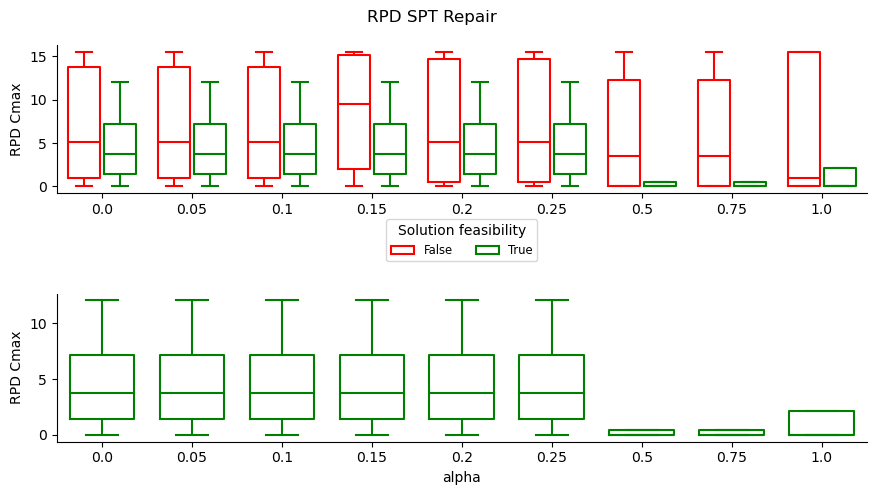



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{SPT with repair procedure}
\label{tab:const_SPT_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 52.00 & 52.00 & 52.00 & 52.00 & 52.00 & 52.00 & 52.00 & 52.00 & 51.00 & 1.96 & 1.96 & 1.96 & 1.96 & 1.96 & 1.96 & 1.96 & 1.96 & 0.00 \\
8 & 2 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 121.00 & 121.00 & 121.0

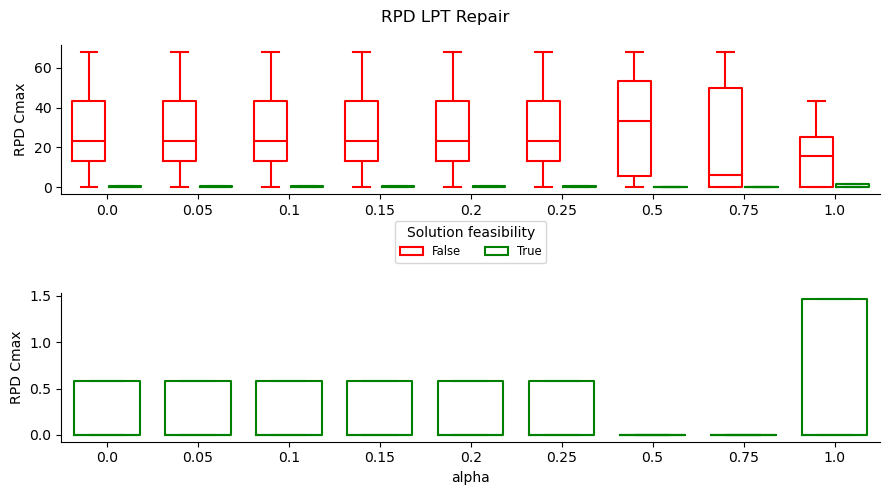



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{LPT with repair procedure}
\label{tab:const_LPT_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 51.00 & 51.00 & 51.00 & 51.00 & 51.00 & 51.00 & 51.00 & 51.00 & 51.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
8 & 2 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 104.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 108.00 & 108.00 & 108.0

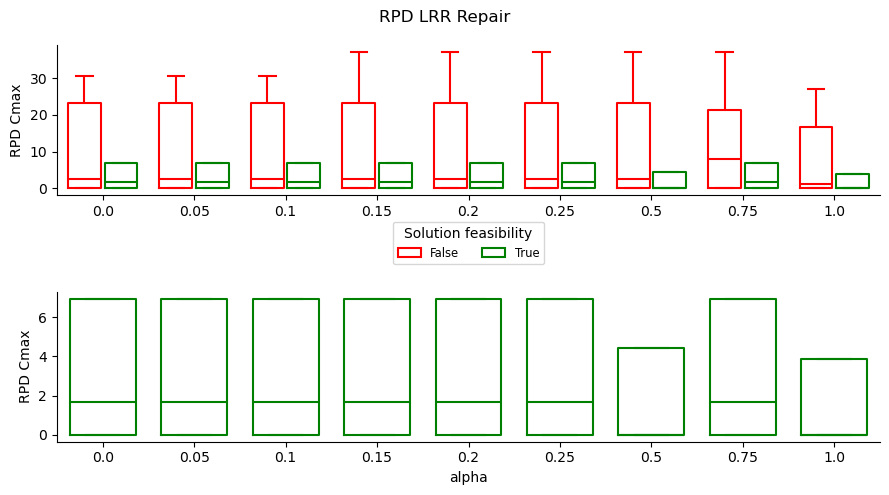



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{LRR with repair procedure}
\label{tab:const_LRR_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 67.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 15.52 \\
8 & 2 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 93.00 & 93.00 & 93.00 & 93.00 &

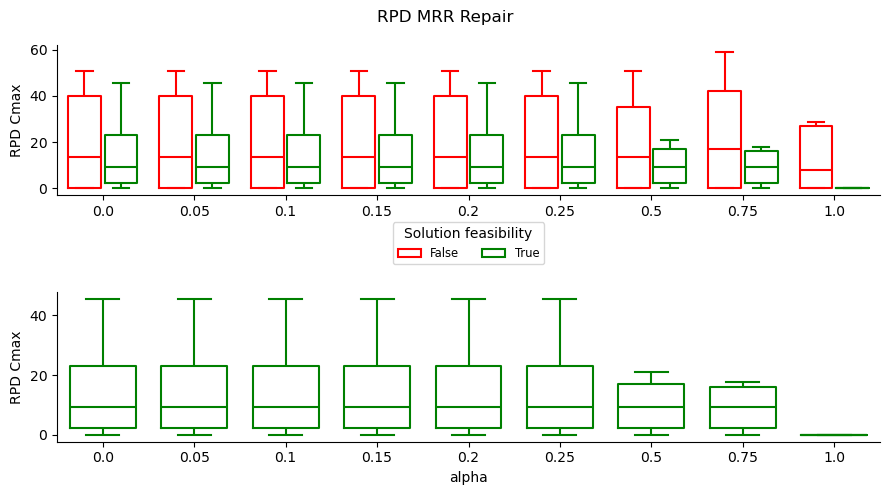



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{MRR with repair procedure}
\label{tab:const_MRR_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 67.00 & 67.00 & 67.00 & 67.00 & 67.00 & 67.00 & 67.00 & 67.00 & 58.00 & 15.52 & 15.52 & 15.52 & 15.52 & 15.52 & 15.52 & 15.52 & 15.52 & 0.00 \\
8 & 2 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 131.00 & 131.00 & 131.00

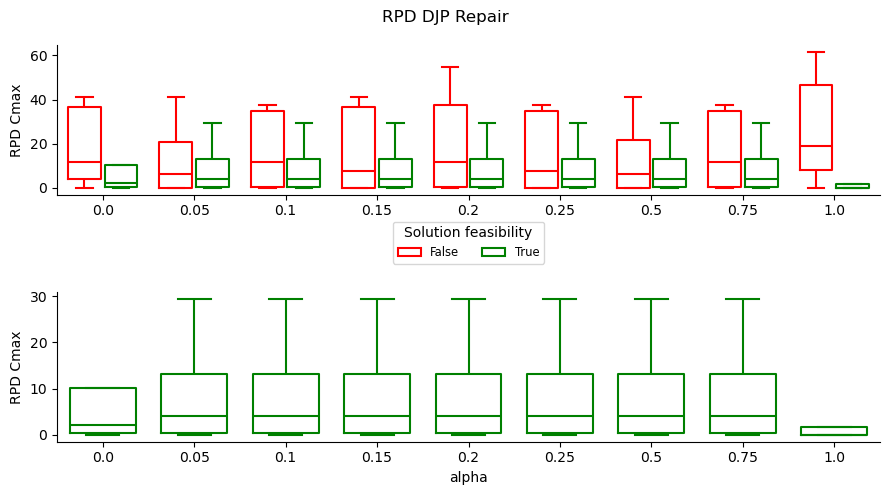



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{DJP with repair procedure}
\label{tab:const_DJP_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 51.00 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 0.00 \\
8 & 2 & 81.00 & 84.00 & 84.00 & 84.00 & 84.00 & 84.00 & 84.00 & 84.00 & 78.00 & 3.85 & 7.69 & 7.69 & 7.69 & 7.69 & 7.69 & 7.69 & 7.69 & 0.00 \\
10 & 2 & 87.00 & 87.00 & 87.00 & 

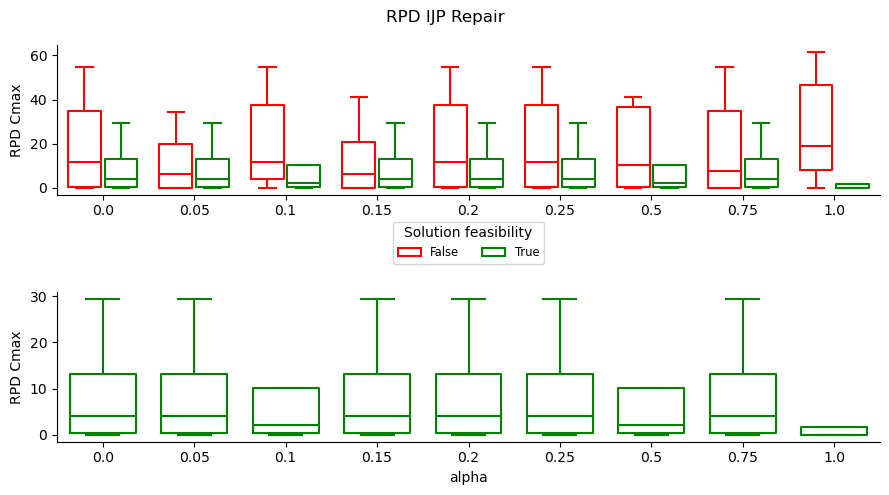



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{IJP with repair procedure}
\label{tab:const_IJP_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 51.00 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 0.00 \\
8 & 2 & 84.00 & 84.00 & 81.00 & 84.00 & 84.00 & 84.00 & 81.00 & 84.00 & 78.00 & 7.69 & 7.69 & 3.85 & 7.69 & 7.69 & 7.69 & 3.85 & 7.69 & 0.00 \\
10 & 2 & 87.00 & 87.00 & 87.00 & 

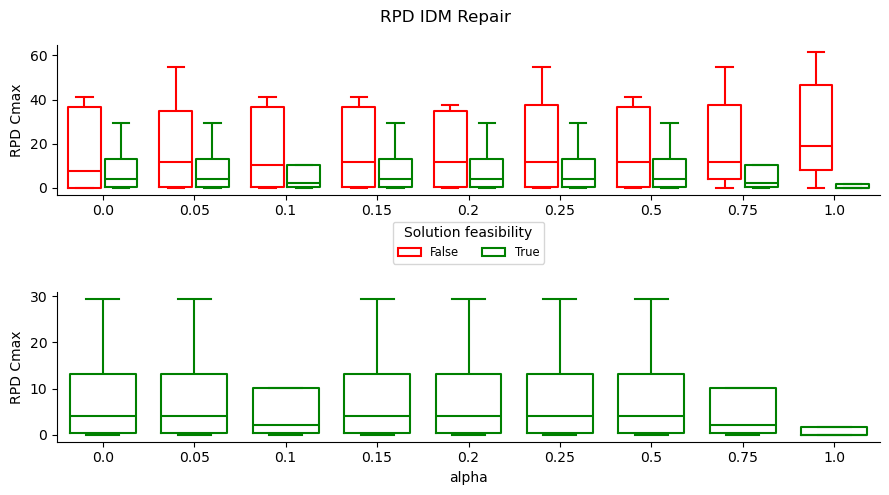



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{IDM with repair procedure}
\label{tab:const_IDM_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 66.00 & 51.00 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 29.41 & 0.00 \\
8 & 2 & 84.00 & 84.00 & 81.00 & 84.00 & 84.00 & 84.00 & 84.00 & 81.00 & 78.00 & 7.69 & 7.69 & 3.85 & 7.69 & 7.69 & 7.69 & 7.69 & 3.85 & 0.00 \\
10 & 2 & 87.00 & 87.00 & 87.00 & 

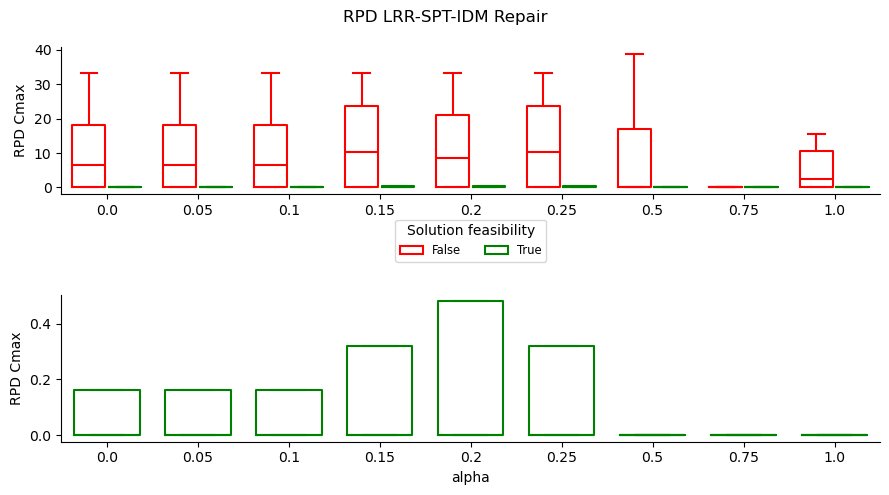



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{LRR-SPT-IDM with repair procedure}
\label{tab:const_LRR-SPT-IDM_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 58.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
8 & 2 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 114.00 & 114.00 

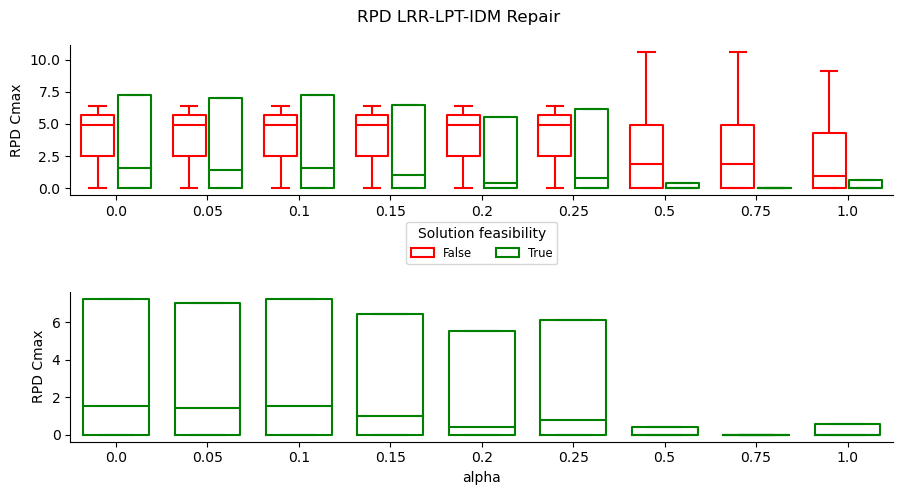



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{LRR-LPT-IDM with repair procedure}
\label{tab:const_LRR-LPT-IDM_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
8 & 2 & 85.00 & 85.00 & 85.00 & 85.00 & 85.00 & 85.00 & 71.00 & 71.00 & 71.00 & 19.72 & 19.72 & 19.72 & 19.72 & 19.72 & 19.72 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 99.00 & 96

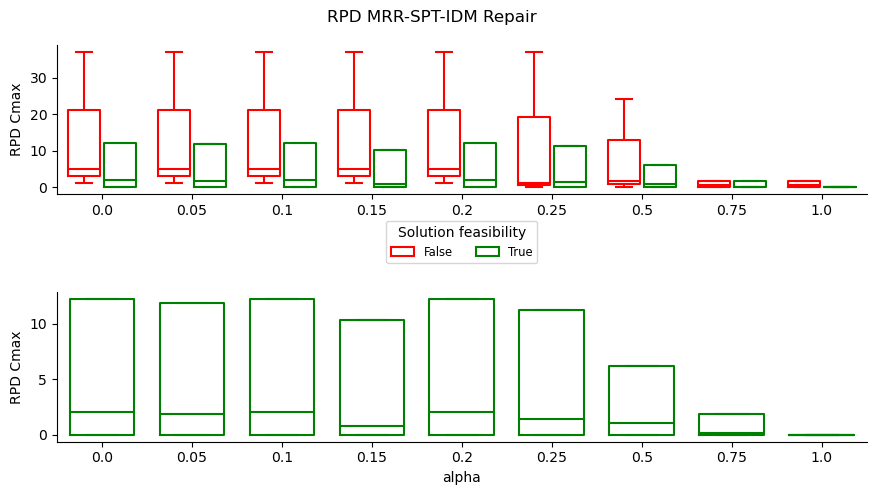



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{MRR-SPT-IDM with repair procedure}
\label{tab:const_MRR-SPT-IDM_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 91.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
8 & 2 & 71.00 & 71.00 & 71.00 & 71.00 & 71.00 & 71.00 & 71.00 & 71.00 & 71.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 131.00 & 131.00 

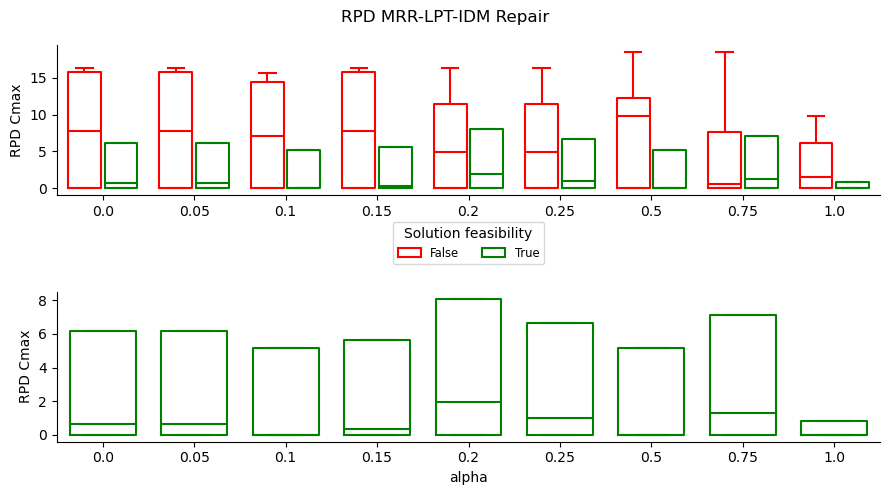



################################################### RPD Makespan Summary ###################################################

\begin{table}[!ht]
\centering
\caption{MRR-LPT-IDM with repair procedure}
\label{tab:const_MRR-LPT-IDM_repair}
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
n & m & \multicolumn{9}{c}{Cmax} & \multicolumn{9}{c}{RPD Cmax} \\
 &  & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ & $\alpha=0.0$ & $\alpha=0.05$ & $\alpha=0.1$ & $\alpha=0.15$ & $\alpha=0.2$ & $\alpha=0.25$ & $\alpha=0.5$ & $\alpha=0.75$ & $\alpha=1.0$ \\
\midrule
6 & 2 & 70.00 & 70.00 & 70.00 & 70.00 & 70.00 & 70.00 & 70.00 & 70.00 & 58.00 & 20.69 & 20.69 & 20.69 & 20.69 & 20.69 & 20.69 & 20.69 & 20.69 & 0.00 \\
8 & 2 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 76.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
10 & 2 & 114.00 &

In [18]:

############################ ALGORITHM CONFIGURATION ############################

parent_path = Path.cwd()

input_data_path = parent_path / 'input_data'
input_debug_path = input_data_path / 'debug'
input_cal_path = input_data_path / 'cal'

output_data_path = parent_path / 'output_data'
output_debug_path = output_data_path / 'debug'
output_cal_path = parent_path / 'output_data' / 'cal'

output_data_path.mkdir(exist_ok=True)

dataset_dict = {0: 'debug', 1: 'cal'}
user_input_dataset = int(input('\nEnter the number of the input dataset (0: debug, 1: cal): '))
instance_type = dataset_dict.get(user_input_dataset)
input_path = input_data_path / dataset_dict.get(user_input_dataset)
output_path = output_data_path / dataset_dict.get(user_input_dataset)
output_path.mkdir(exist_ok=True)

instances = [instance.name for instance in sorted(input_path.glob('*.txt'))]

print(f'\nInput data path: {input_path}')
print(f'\nInstances: {instances}')

os.chdir(input_path)

sol_name = ''
instance_sol = {}
instance_sol_keys = ['Size', 'Precedences', 'Resources', 'Feasibility', 'Alpha', 'Cmax']

# greedy_rules = ['LRR-SPT-IDM']
# greedy_rules = ['LRR-SPT-IDM', 'LRR-LPT-IDM', 'MRR-SPT-IDM', 'MRR-LPT-IDM']
greedy_rules = ['SPT', 'LPT', 'LRR', 'MRR', 'DJP', 'IJP', 'IDM', 'LRR-SPT-IDM', 'LRR-LPT-IDM', 'MRR-SPT-IDM', 'MRR-LPT-IDM']

# user_alpha_steps = int(input('\nEnter the number of alpha values to be used to generate the restricted candidate list [0, 11]: '))
# alpha_values = np.linspace(0,1,user_alpha_steps)

alpha_values = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 1.00]
# alpha_values = [0.00, 0.15, 0.50, 0.75, 1.00]

alpha_dict = {}
alpha_columns = []
makespan_columns = []
rpd_makespan_columns = []
for i,v in enumerate(alpha_values):
    alpha_dict.update({i:v})
    alpha_columns.append(f'Alpha (alpha={str(v)})')
    makespan_columns.append(f'Cmax (alpha={str(v)})')
    rpd_makespan_columns.append(f'RPD Cmax (alpha={str(v)})')

for g_rule in greedy_rules:

    g_rule_summary_df = pd.DataFrame()

    print('\n\n' + str(' Greedy rule: ' + g_rule + ' ').center(124, '#')) # 483

    for alpha_value in alpha_values:

        a_rule_summary_df = pd.DataFrame()

        instance_name_list = []
        print()

        for instance in instances:
    
            ############################ DATA LOADING ############################
    
            load_start_time = time.monotonic()
            instance_name = instance.rstrip('.txt')
            instance_name_list.append(instance_name)
            print(f'> alpha = {str(round(alpha_value, 4))}: {instance_name_list}', end='\r')
            problem_df = read_instance(instance)
            instance_size = 'x'.join([str(M), str(J)])
            load_end_time = time.monotonic()
            load_time = (load_end_time - load_start_time)
    
            ############################ MULTI-START ############################
    
            random.seed(42)

            instance_summary_dict = {'Size': [instance_size] * 4, 
                                     'Precedences': [False, False, True, True], 
                                     'Resources': [False, True, False, True],
                                     'Feasibility': [False, False, False, True], 
                                     'Alpha': [alpha_value] * 4}
            instance_summary_df = pd.DataFrame.from_dict(instance_summary_dict, 'columns')
            instance_df = pd.DataFrame()
    
            for key in instance_sol_keys:
                instance_sol[key] = []
    
            Cmax_const_f = np.inf
            Cmax_const_u = np.inf
            
            # Solution dictionaries
            sol_dict_f = {} # feasible solution dictionary
            sol_dict_u = {} # unfeasible solution dictionary
    
            # Job dashboards
            job_dash_const = {} # job dashboard
            job_dash_f = {} # feasible job dashboard
            job_dash_u = {} # unfeasible job dashboard

            best_job_dash = {} # job dashboard
            best_job_dash_f = {} # feasible job dashboard
            best_job_dash_u = {} # unfeasible job dashboard

            best_grasp_f_dict = {}
            best_grasp_u_dict = {}
            best_grasp_r_dict = {}
            best_grasp_sol_dict = {}

            best_grasp_f_Cmax = np.inf
            best_grasp_f_sol = []
            best_grasp_f_dict.update({best_grasp_f_Cmax: best_grasp_f_sol})

            best_grasp_u_Cmax = np.inf
            best_grasp_u_sol = []
            best_grasp_u_dict.update({best_grasp_u_Cmax: best_grasp_u_sol})

            best_grasp_r_Cmax = np.inf
            best_grasp_r_sol = []
            best_grasp_r_dict.update({best_grasp_r_Cmax: best_grasp_r_sol})

            # Solution output
            instance_Cmax = np.inf
            instance_sol_df = pd.DataFrame()
    
            # Iteration counters
            grasp_iter = 0
    
            # Timers
            grasp_time = 0
            construct_time = 0
    
            instance_T = float(J * M)
            
            while grasp_time < instance_T:
    
                grasp_iter += 1
    
                ############################ CONSTRUCTIVE PHASE ############################
    
                construct_start_time = time.monotonic()
    
                job_list = create_jobs(problem_df)
                dict_const, sol_const, Cmax_const, const_prec_ok, const_res_ok, job_dash_const = construct_initial_solution(job_list, g_rule, alpha_value)
                initial_feasibility = const_prec_ok and const_res_ok
                
                sol_values = [instance_size, const_prec_ok, const_res_ok, initial_feasibility, alpha_value, Cmax_const]
                for key, value in zip(instance_sol.keys(), sol_values):
                    instance_sol[key].append(value)

                if (initial_feasibility) and (Cmax_const < best_grasp_f_Cmax):
                    job_dash_f.update(job_dash_const)
                    best_grasp_f_dict.clear() # Comment this line if the nuimber of feasible solutions should be reduced to one
                    # best_grasp_f_Cmax = list(dict_const.keys())[0]
                    best_grasp_f_Cmax = Cmax_const
                    best_grasp_f_dict.update(dict_const)
                    # best_job_dash_f.update(job_dash_const)
                    sol_name_f = instance_name + '_' + g_rule + '_' + str(alpha_value).replace('.','')[:2] + '_f.csv'
                elif (not initial_feasibility) and (Cmax_const < best_grasp_u_Cmax):
                    const_prec_ok_u = const_prec_ok
                    const_res_ok_u = const_res_ok
                    job_dash_u.update(job_dash_const)
                    best_grasp_u_dict.clear() # Comment this line if the nuimber of feasible solutions should be reduced to one
                    # best_grasp_u_Cmax = list(dict_const.keys())[0]
                    best_grasp_u_Cmax = Cmax_const
                    best_grasp_u_dict.update(dict_const)
                    # best_job_dash_u.update(job_dash_const)                
                    sol_name_u = instance_name + '_' + g_rule + '_' + str(alpha_value).replace('.','')[:2] + '_u.csv'
                
                construct_end_time = time.monotonic()
                construct_time += (construct_end_time - construct_start_time)
                grasp_time += construct_time

            ############################ REPAIR ############################

            if len(job_dash_f) > 0:
                best_job_dash_f.update(job_dash_f)
                # print(f'\nBest local feasible solution Cmax: {best_grasp_f_Cmax}')

            if len(job_dash_u) > 0:
                best_job_dash_u.update(job_dash_u)
                # print(f'\nBest local unfeasible solution Cmax: {best_grasp_u_Cmax}')
                best_grasp_r_dict, Cmax_repair, const_prec_ok_r, const_res_ok_r, best_job_dash_r = repair(best_grasp_u_dict, const_prec_ok_u, const_res_ok_u, job_dash_u, instance_T)
                # The repaired solution, either feasible or not, is appended to the instance solution set
                repair_feasibility = const_prec_ok_r and const_res_ok_r
                sol_values = [instance_size, const_prec_ok_r, const_res_ok_r, repair_feasibility, alpha_value, Cmax_repair]
                for key, value in zip(instance_sol.keys(), sol_values):
                    instance_sol[key].append(value)
                if (repair_feasibility) and (Cmax_repair < best_grasp_r_Cmax):
                    # job_dash_r.update(job_dash_const)
                    # best_grasp_r_dict.clear() # Comment this line if the nuimber of feasible solutions should be reduced to one
                    # best_grasp_r_Cmax = list(best_grasp_r_dict.keys())[0]
                    best_grasp_r_Cmax = Cmax_repair
                    # print(f'\nBest local repaired solution Cmax: {best_grasp_r_Cmax}')
                    # best_grasp_r_dict.update(dict_const)
                    # best_job_dash_f.update(job_dash_const)
                    sol_name_r = instance_name + '_' + g_rule + '_' + str(alpha_value).replace('.','')[:2] + '_r.csv'

            ############################ XXX ############################
            
            instance_sol_df = pd.DataFrame.from_dict(instance_sol, orient='columns', dtype=None)
            instance_info_df = instance_sol_df.groupby(by=['Size', 'Precedences', 'Resources', 'Feasibility', 'Alpha'], as_index=False).describe(include='all')
            # Flatten the columns by joining the levels with an underscore:
            instance_info_df.columns = ['_'.join(filter(None, col)).strip() for col in instance_info_df.columns]
            instance_summary_df = pd.merge(instance_summary_df, instance_info_df, 
                                           how='left', 
                                           on=['Size', 'Precedences', 'Resources', 'Feasibility', 'Alpha']
                                          ).fillna({'Value': 0})
            a_rule_summary_df = pd.concat([a_rule_summary_df, instance_summary_df], axis=0, ignore_index=True)
            
            ############################ GENERATE SOLUTION ############################
    
            if (best_grasp_f_Cmax <= best_grasp_r_Cmax) and (best_grasp_f_Cmax < np.inf):
                instance_sol_df = generate_solution(best_grasp_f_dict.get(best_grasp_f_Cmax))
                sol_file_path = os.path.join(output_path, sol_name_f)
                instance_sol_df.to_csv(sol_file_path, sep=';', header=True, index=True, mode='w', decimal=',')
            elif best_grasp_r_Cmax < best_grasp_f_Cmax:
                instance_sol_df = generate_solution(best_grasp_r_dict.get(best_grasp_r_Cmax))
                sol_file_path = os.path.join(output_path, sol_name_r)
                instance_sol_df.to_csv(sol_file_path, sep=';', header=True, index=True, mode='w', decimal=',')
            
        a_rule_summary_df.drop(columns=['Cmax_mean', 'Cmax_std', 'Cmax_25%', 'Cmax_50%', 'Cmax_75%', 'Cmax_max'], 
                               inplace=True)
        a_rule_summary_df.rename(columns={'Alpha': f'Alpha (alpha={str(alpha_value)})', 
                                          'Cmax_count': f'Solutions (alpha={str(alpha_value)})', 
                                          'Cmax_min': f'Cmax (alpha={str(alpha_value)})'}, 
                                 inplace=True)
        a_rule_summary_df[f'RPD Cmax (alpha={str(alpha_value)})'] = np.nan*np.ones_like(a_rule_summary_df.iloc[:,-1].values)

        if g_rule_summary_df.empty:
            g_rule_summary_df = pd.DataFrame(a_rule_summary_df)
        else:
            g_rule_summary_df = pd.merge(g_rule_summary_df, a_rule_summary_df, 
                                         how='inner', 
                                         on=['Size', 'Precedences', 'Resources', 'Feasibility'])
        
    ############################ FINAL EVALUATION ############################

    os.chdir(output_path)
    output_name = instance_type + '_' + g_rule + '-r.csv'
    output_file_path = output_path / output_name

    summary_rpd_df = g_rule_summary_df.copy(deep=True)
    
    for group_values, group_idx in summary_rpd_df.groupby(by=["Size", "Feasibility"]).groups.items():
        makespan_inst = summary_rpd_df.loc[group_idx, makespan_columns]
        makespan_min = np.nanmin(makespan_inst)
        for makespan_column, rpd_makespan_column in zip(makespan_columns, rpd_makespan_columns):
            summary_rpd_df.loc[group_idx, rpd_makespan_column] = round((summary_rpd_df.loc[group_idx, makespan_column] - makespan_min) / makespan_min * 100, 4)

    output_solution(summary_rpd_df, alpha_values, makespan_columns, rpd_makespan_columns, g_rule, output_path)
    summary_rpd_df.drop(columns=alpha_columns, inplace=True)
    summary_rpd_df.to_csv(output_file_path, float_format='%.4f', sep=';', header=True, index=False, mode='w', decimal=',')

    del instance_summary_df, a_rule_summary_df, g_rule_summary_df, summary_rpd_df
    
    os.chdir(input_path)
    
os.chdir(parent_path)
